# DON'T USE ME

In [2]:
import lightkurve as lk
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.stats import sigma_clipped_stats, sigma_clip
import numpy as np
from scipy.signal import medfilt
from astropy.convolution import convolve, Box1DKernel, Box2DKernel, Gaussian2DKernel
from astropy.stats import LombScargle
plt.style.use(lk.MPLSTYLE)
from tqdm import tqdm

import starry
from starry.kepler import Primary, Secondary, System

#period, t0 = 1.6696334816740839, 1363.1389770507812
period, t0 = 1.669530708135147, 0.7945727531770768

In [34]:
import sys
sys.path.append('/Users/ch/Hacks/TESSparty/chromo/chromo')
from utils import MidPointNorm

In [35]:
def poly_detrend(lc):
    ''' Detrend a light curve with a simple third order polynomial
    '''
    clc = lc.copy()
    split = np.where(np.diff(clc.time) > 0.5)[0][0]+1
    f = clc[:split].remove_outliers(3)
    corr = lk.LightCurve(clc[:split].time, np.polyval(np.polyfit(f.time, f.flux, 3), clc[:split].time))

    f = clc[split:].remove_outliers(3)
    corr = corr.append(lk.LightCurve(clc[split:].time, np.polyval(np.polyfit(f.time, f.flux, 3), clc[split:].time)))
    return corr

In [36]:
tpf = lk.TessTargetPixelFile('../data/zet-phe2.fits')
tpf = tpf[~(np.nansum(tpf.flux, axis=(1,2)) == 0)]

In [37]:
flux = tpf.flux
thumb = np.nanpercentile(flux, 95, axis=0)
mask = thumb > np.nanpercentile(thumb[:, 42:], 10)

# Make sure to throw away the edge
mask[:, :42] = True
mask[~np.isfinite(thumb)] = True

# Build a background estimate using astropy sigma clipping
mean, med, sigma = np.asarray([sigma_clipped_stats(f, mask=mask) for f in flux]).T

# Remove the median background
flux = tpf.flux - np.atleast_3d(med).transpose([1, 2, 0])
flux = flux[:, 3:, 42:-42]

# HAVE to add the minimum back in, otherwise some flux values are negative!
flux -= np.min(flux)

flux_err = tpf.flux_err
flux_err = flux_err[:, 3:, 42:-42]
aper = tpf.pipeline_mask[3:, 42:-42]

In [38]:
x_fold = (tpf.time - t0 - period/2) / period % 1 - 0.5

In [39]:
saturated = np.nanmax(flux, axis=0) > 100000
for idx, s in enumerate(saturated.T):
    saturated[:, idx] = (convolve(s, Box1DKernel(5)) > 1e-5)

saturated |= np.nanmax(flux, axis=0) > 50000
for idx, s in enumerate(saturated.T):
    saturated[:, idx] = (convolve(s, Box1DKernel(10)) > 1e-5)

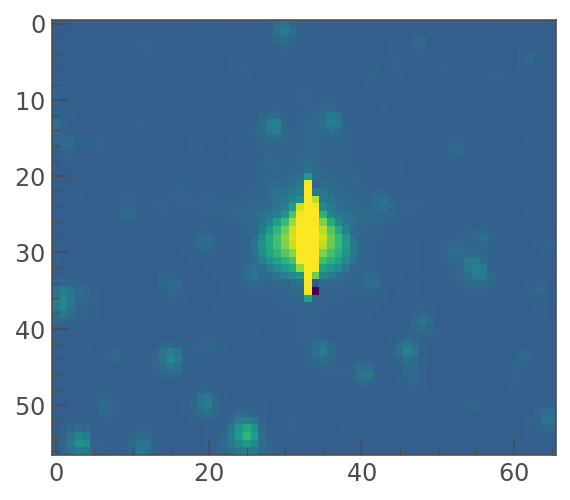

In [40]:
plt.imshow(np.log10(flux[0]))

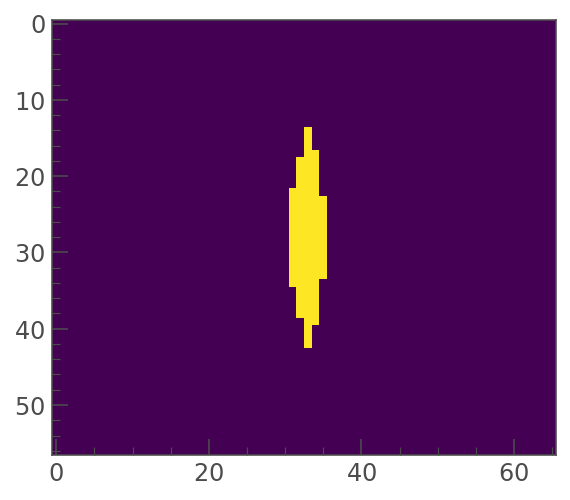

In [41]:
plt.imshow(saturated)

In [42]:
all_aper = np.ones(flux.shape[1:], bool)

In [43]:
true = lk.LightCurve(tpf.time, np.nansum(flux[:, all_aper], axis=(1))).normalize()

In [44]:
#p = true.to_periodogram('bls', minimum_period=1.64, maximum_period=1.69, frequency_factor=0.1, duration=0.15)
#p.plot()

In [45]:
#p.period_at_max_power.value, p.transit_time_at_max_power

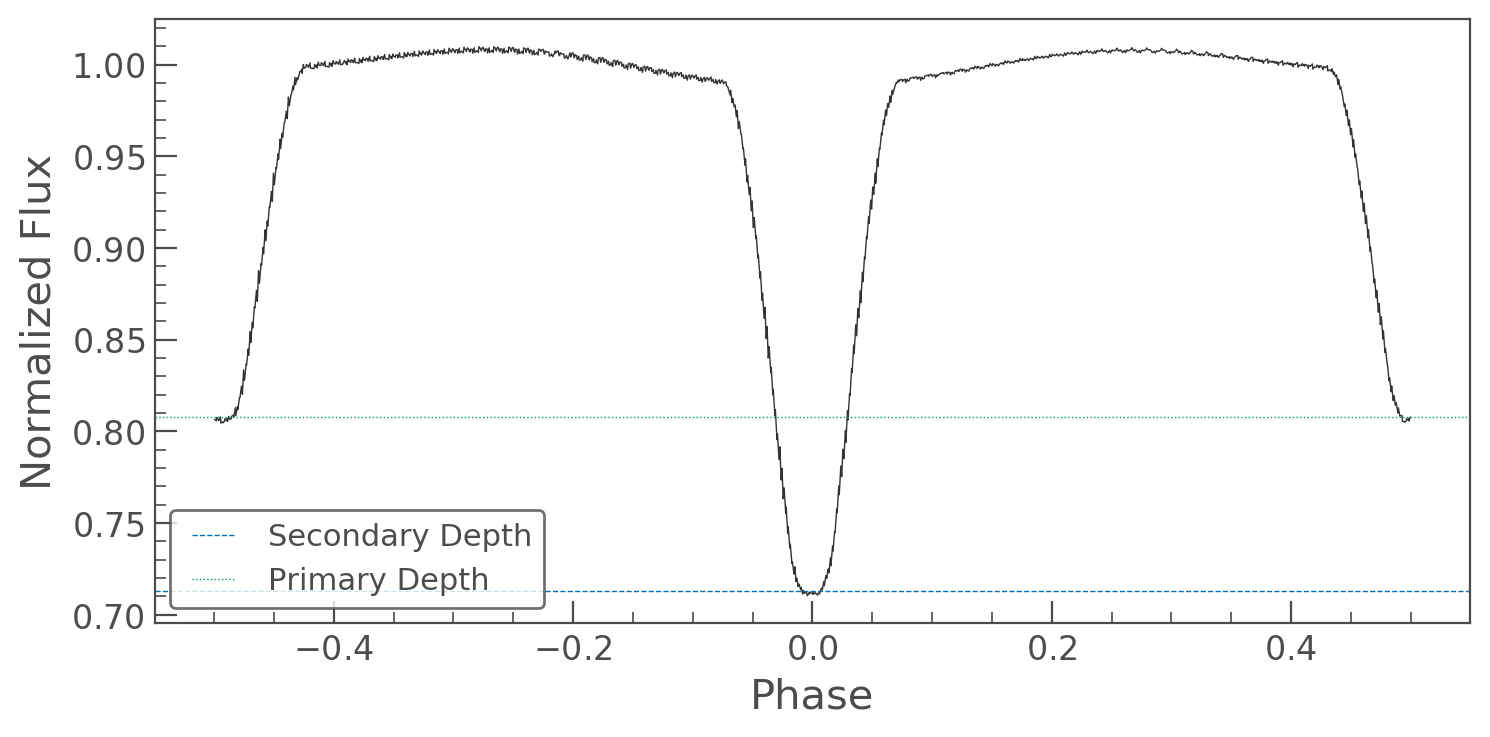

In [46]:
true_primary_depth = np.nanmedian(true.flux[np.abs(x_fold) < 0.015])
true_secondary_depth = np.nanmedian(true.flux[np.abs(x_fold) > 0.48])

ax = true.fold(period, t0).plot()
ax.axhline(true_primary_depth, color='C1', ls='--', label='Secondary Depth')
ax.axhline(true_secondary_depth, color='C2', ls=':', label='Primary Depth')
ax.legend()

In [67]:
c_flux = np.zeros(flux.shape)
primary_depth = np.zeros(flux.shape[1:])
secondary_depth = np.zeros(flux.shape[1:])

primary_depth_err = np.zeros(flux.shape[1:])
secondary_depth_err = np.zeros(flux.shape[1:])

std = np.zeros(flux.shape[1:])

for jdx in tqdm(range(flux.shape[2])):
    for idx in range(flux.shape[1]):
        # BUILD a lk object
        l1 = lk.LightCurve(tpf.time, flux[:, idx, jdx], flux_err=flux_err[:, idx, jdx])
        # Detrend long term
        l1 /= poly_detrend(l1).flux
        primary_depth[idx, jdx] = np.nanmedian(l1.flux[np.abs(x_fold) < 0.015])
        primary_depth_err[idx, jdx] = np.nanstd(l1.flux[np.abs(x_fold) < 0.015])

        #d = (1 - primary_depth[idx, jdx])/(1 - true_primary_depth)
        #l1 = (l1* (1/d) - (1/d) + 1)
        secondary_depth[idx, jdx] = np.nanmedian(l1.flux[np.abs(x_fold) > 0.48])
        secondary_depth_err[idx, jdx] = np.nanstd(l1.flux[np.abs(x_fold) > 0.48])
        
        std[idx, jdx] = (l1/true.flux)[(np.abs(x_fold) > 0.1) & (np.abs(x_fold) < 0.4)].flux.std()
        c_flux[:, idx, jdx] = l1.flux
        
        
#c_flux[:, saturated] = np.nan
primary_depth[saturated] = np.nan
secondary_depth[saturated] = np.nan
#primary_depth_err[saturated] = np.nan
#secondary_depth_err[saturated] = np.nan
#std[saturated] = np.nan

100%|██████████| 66/66 [00:10<00:00,  6.17it/s]


In [68]:
#plt.imshow(std#, vmax=0.5)
#plt.colorbar()

In [69]:
aper = (primary_depth < 0.99) & ~saturated
#c_flux[:, ~aper] = np.nan
#primary_depth[~aper] = np.nan
#secondary_depth[~aper] = np.nan
#primary_depth_err[~aper] = np.nan
#secondary_depth_err[~aper] = np.nan

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


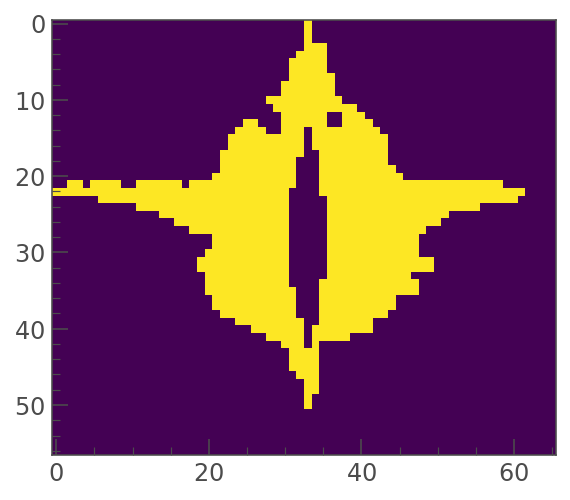

In [70]:
plt.imshow(aper)

(0, 1.5)

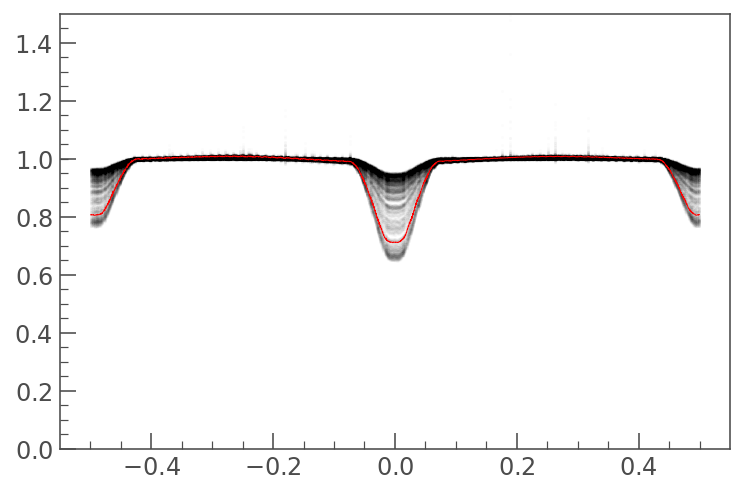

In [51]:
plt.plot(x_fold, c_flux[:, aper], 'k.', alpha=0.01);
plt.plot(true.fold(period, t0).time, true.fold(period, t0).flux, c='r')
plt.ylim(0, 1.5)

In [52]:
norm_depth_ratio = secondary_depth[all_aper]/primary_depth[all_aper] - true_secondary_depth/true_primary_depth

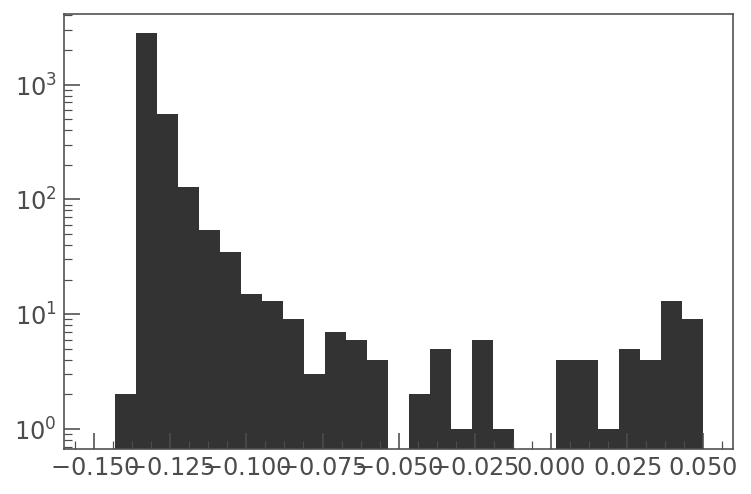

In [53]:
plt.hist(norm_depth_ratio[np.isfinite(norm_depth_ratio)], np.linspace(-0.15, 0.05, 30));
plt.yscale('log')

In [54]:
x_fold = (tpf.time - t0 - period/2) / period % 1 - 0.5
inds = np.array_split(np.argsort(x_fold), np.linspace(0, len(x_fold), 100, dtype=int))[1:-1]
x_fold_b = np.asarray([np.median(x_fold[ind]) for ind in inds])
c_flux_b = np.asarray([np.median(c_flux[ind, :, :], axis=0) for ind in inds])
true_flux_b = np.asarray([np.median(true.flux[ind]) for ind in inds])

In [55]:
cmap = plt.get_cmap('RdBu')
norm = MidPointNorm(midpoint=0, vmin=-0.15, vmax=0.05)
cmap.set_bad('lightgrey', 1)

Text(0,0.5,'Pixel Light Curves')

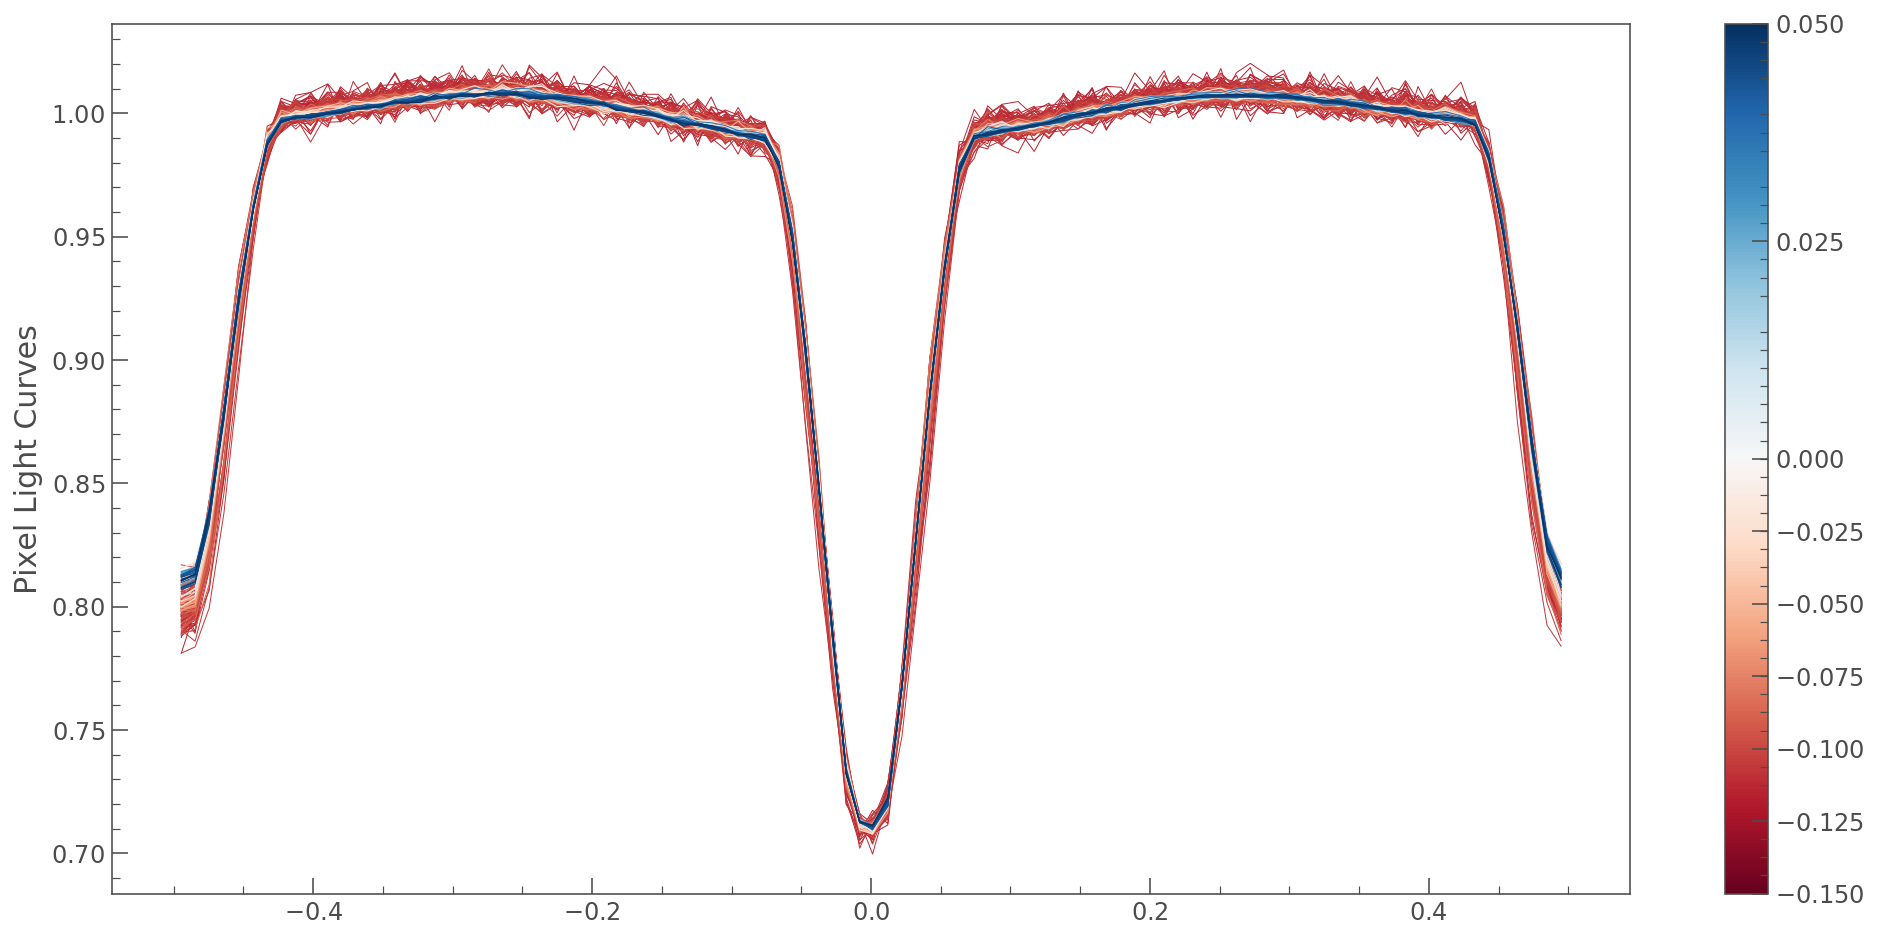

In [56]:

# Matplot lib stuff
fig, ax = plt.subplots(figsize=(17, 8))

for l, s, p in zip(c_flux_b[:, aper].T, secondary_depth[aper], primary_depth[aper]):
    c = (s/p - true_secondary_depth/true_primary_depth)
    d = (1 - p)/(1 - true_primary_depth)
    l2 = (l * (1/d) - (1/d) + 1)
    ax.plot(x_fold_b, l2, color=cmap(norm(c)), zorder=c)

#Horrible Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Measured Secondary Depth/\nTrue Secondary Depth')
ax.set_ylabel('Pixel Light Curves')



Text(0,1.02,'PRIMARY')

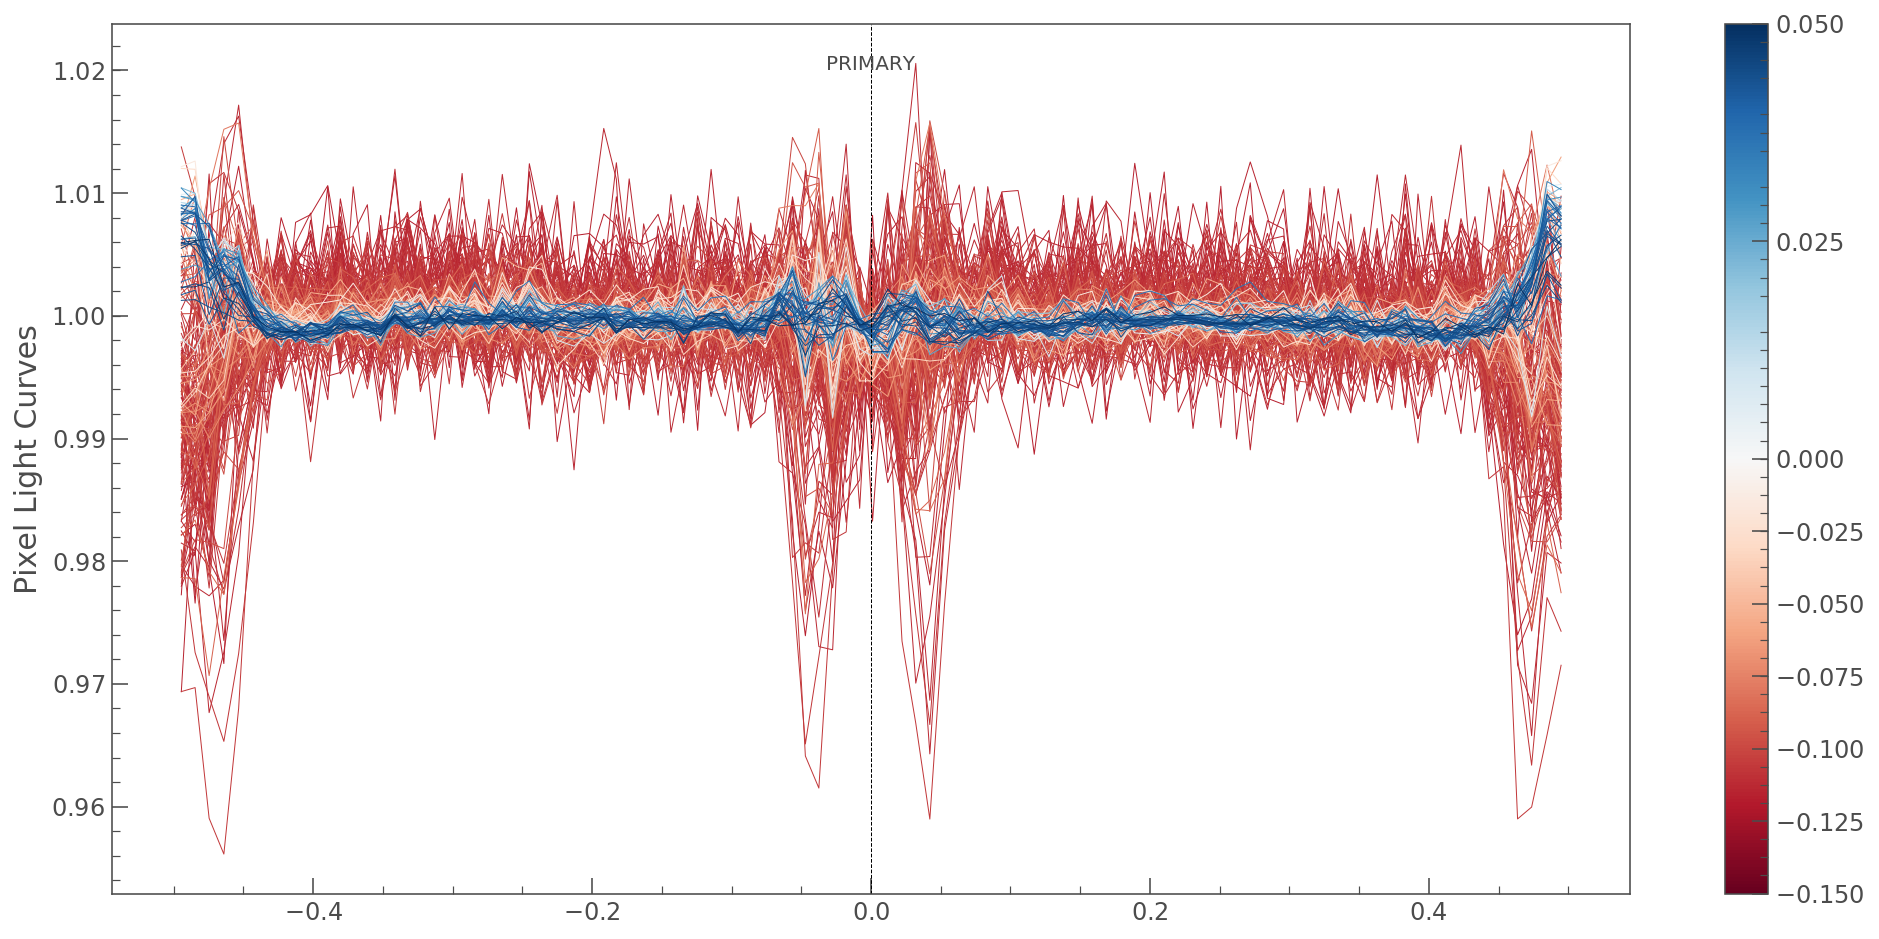

In [57]:
# Matplot lib stuff
fig, ax = plt.subplots(figsize=(17, 8))

for l, s, p in zip(c_flux_b[:, aper].T, secondary_depth[aper], primary_depth[aper]):
    c = (s/p - true_secondary_depth/true_primary_depth)
    d = (1 - p)/(1 - true_primary_depth)
    l2 = (l * (1/d) - (1/d) + 1)
    ax.plot(x_fold_b, l2/true_flux_b, color=cmap(norm(c)), zorder=c)

#Horrible Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Measured Secondary Depth/\nTrue Secondary Depth')
ax.set_ylabel('Pixel Light Curves')
ax.axvline(0, ls='--', color='k')
ax.text(0, 1.02, 'PRIMARY', ha='center')



(0, 1)

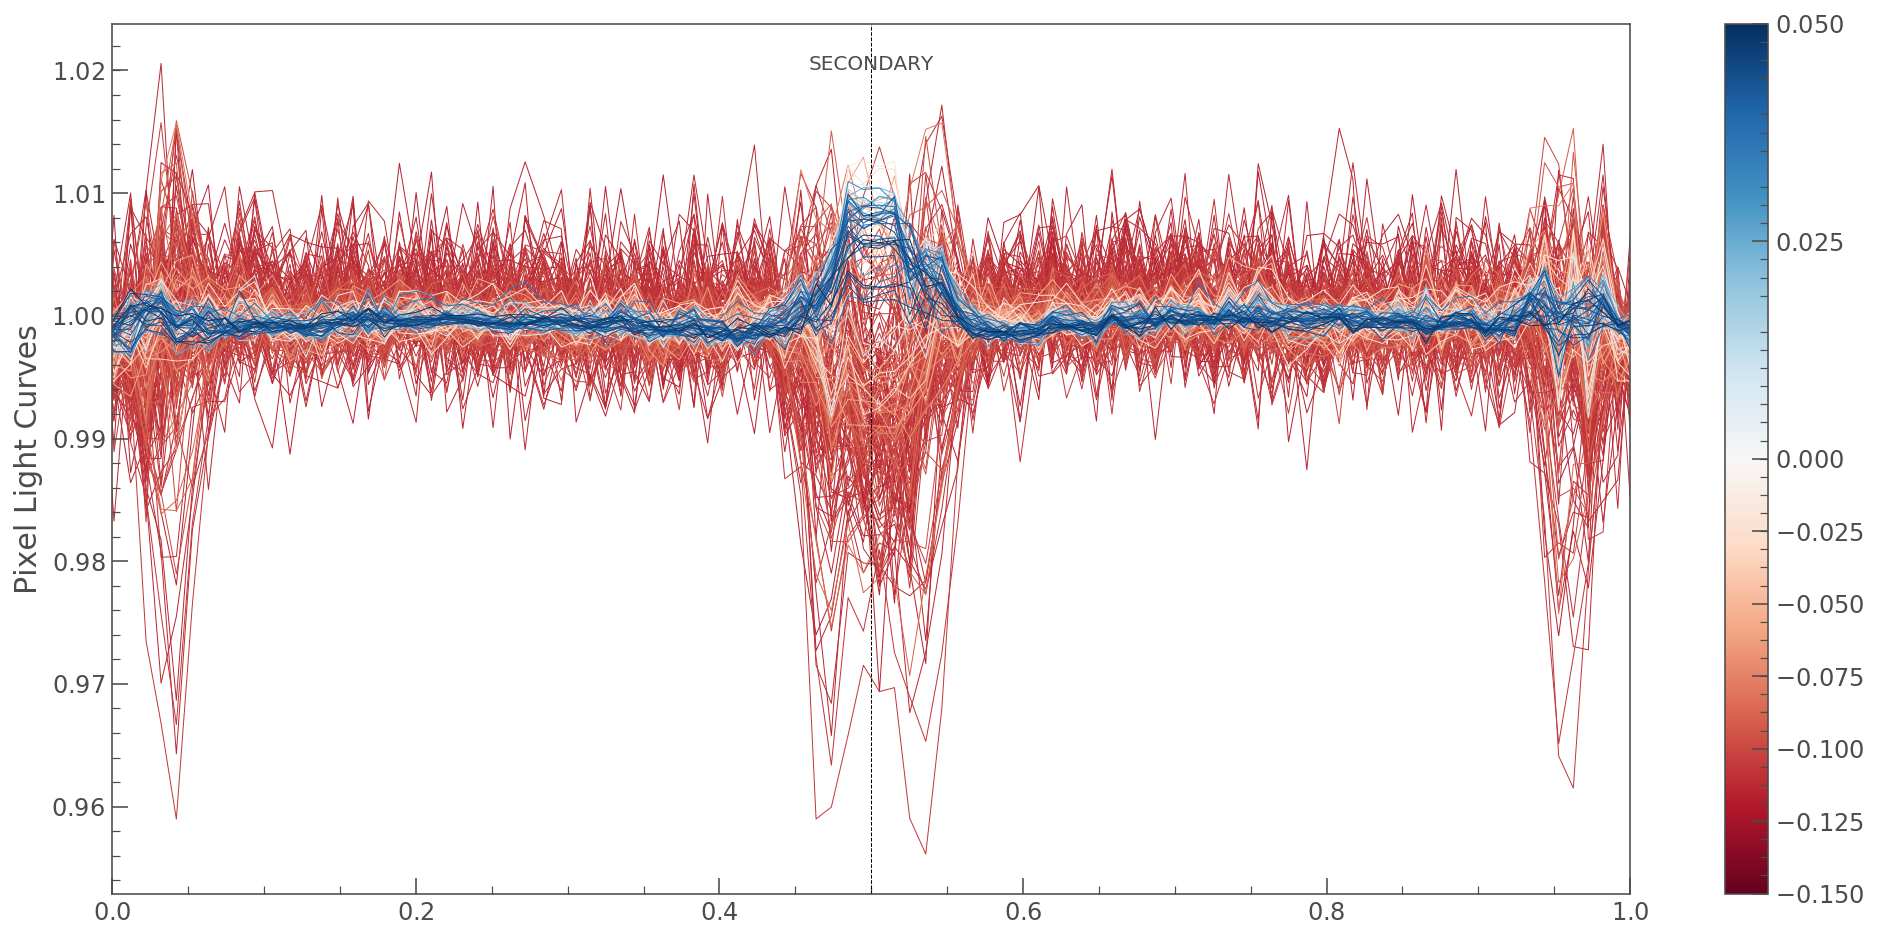

In [58]:
# Matplot lib stuff
fig, ax = plt.subplots(figsize=(17, 8))

for l, s, p in zip(c_flux_b[:, aper].T, secondary_depth[aper], primary_depth[aper]):
    c = (s/p - true_secondary_depth/true_primary_depth)
    d = (1 - p)/(1 - true_primary_depth)
    l2 = (l * (1/d) - (1/d) + 1)
    
    x, y = np.hstack([x_fold_b, x_fold_b + 1]), np.hstack([l2/true_flux_b, l2/true_flux_b])
    ax.plot(x, y, color=cmap(norm(c)), zorder=c)
#    ax.plot(x_fold_b + 1, l2/true_flux_b, color=cmap(norm(c)), zorder=c)


#Horrible Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Measured Secondary Depth/\nTrue Secondary Depth')
ax.set_ylabel('Pixel Light Curves')
ax.axvline(0.5, ls='--', color='k')
ax.text(0.5, 1.02, 'SECONDARY', ha='center')
ax.set_xlim(0, 1)

/Users/ch/Hacks/TESSparty/chromo/chromo/utils.py:41: RuntimeWarning: invalid value encountered in greater
  resdat[resdat>0] /= abs(vmax - midpoint)
/Users/ch/Hacks/TESSparty/chromo/chromo/utils.py:42: RuntimeWarning: invalid value encountered in less
  resdat[resdat<0] /= abs(vmin - midpoint)


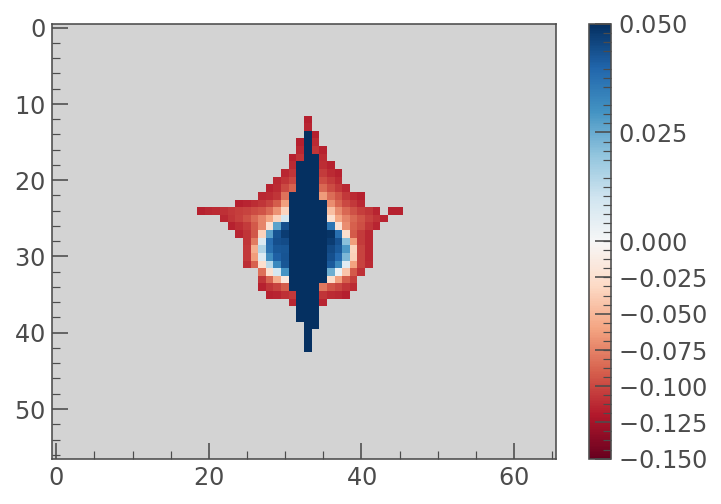

In [59]:
im = norm_depth_ratio.reshape(flux.shape[1:])
im[~aper] = np.nan
im[saturated] = 1
plt.imshow(im, norm=norm, cmap=cmap)
plt.colorbar()